# 毕业项目：为 Arvato Financial Services 金融服务公司实现一个顾客分类报告

该项目要求你分析德国的一家邮购公司的顾客的人口统计数据，将它和一般的人口统计数据进行比较。你将使用非监督学习技术来实现顾客分类，识别出哪些人群是这家公司的基础核心用户。之后，你将把所学的知识应用到第三个数据集上，该数据集是该公司的一场邮购活动的营销对象的人口统计数据。用你搭建的模型预测哪些人更可能成为该公司的顾客。你要使用的数据由我们的合作伙伴 Bertelsmann Arvato Analytics 公司提供。这是真实场景下的数据科学任务。

如果你完成了这个纳米学位的第一学期，做过其中的非监督学习项目，那么你应该对这个项目的第一部分很熟悉了。两个数据集版本不同。这个项目中用到的数据集会包括更多的特征，而且没有预先清洗过。你也可以自由选取分析数据的方法，而不用按照既定的步骤。如果你选择完成的是这个项目，请仔细记录你的步骤和决策，因为你主要交付的成果就是一篇博客文章报告你的发现。

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
workspace_path = {'windows': 'C:\\Data\\avator_data\\', 
                  'udactity': '../../data/Term2/capstone/arvato_data/'}
drive_path = workspace_path['windows']

## 第 0 部分：了解数据

项目数据中包括四个数据文件

- `Udacity_AZDIAS_052018.csv`: 德国的一般人口统计数据；891211 人（行）x 366 个特征（列）
- `Udacity_CUSTOMERS_052018.csv`: 邮购公司顾客的人口统计数据；191652 人（行）x 369 个特征（列）
- `Udacity_MAILOUT_052018_TRAIN.csv`: 营销活动的对象的人口统计数据；42982 人（行）x 367 个特征（列）
- `Udacity_MAILOUT_052018_TEST.csv`: 营销活动的对象的人口统计数据；42833 人（行）x 366个特征（列）

人口统计数据的每一行表示是一个单独的人，也包括一些非个人特征，比如他的家庭信息、住房信息以及周边环境信息。使用前两个数据文件中的信息来发现顾客（"CUSTOMERS"）和一般人（"AZDIAS"）在何种程度上相同和不同，然后根据你的分析对其余两个数据文件（"MAILOUT"）进行预测，预测更可能成为该邮购公司的客户。

"CUSTOMERS" 文件包括三个额外的列（'CUSTOMER_GROUP'、’'ONLINE_PURCHASE' 和 'PRODUCT_GROUP'），提供了文件中顾客的更多维度的信息。原始的 "MAILOUT" 包括一个额外的列 "RESPONSE"，表示每个收到邮件的人是否成为了公司的顾客。对于 "TRAIN" 子数据集，该列被保留，但是在 "TEST" 子数据集中该列被删除了，它和你最后要在 Kaggle 比赛上预测的数据集中保留的列是对应的。

三个数据文件中其他的所有列都是相同的。要获得关于文件中列的更多信息，你可以参考 Workspace 中的两个 Excel 电子表格。[其一](./DIAS Information Levels - Attributes 2017.xlsx) 是一个所有属性和描述的列表，按照信息的类别进行排列。[其二](./DIAS Attributes - Values 2017.xlsx) 是一个详细的每个特征的数据值对应关系，按照字母顺序进行排列。

在下面的单元格中，我们提供了一些简单的代码，用于加载进前两个数据集。注意，这个项目中所有的 `.csv` 数据文件都是分号(`;`) 分割的，所以 [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) 中需要加入额外的参数以正确地读取数据。而且，考虑数据集的大小，加载整个数据集可能会花费一些时间。


你会注意到在数据加载的时候，会弹出一个警告（warning）信息。在你开始建模和分析之前，你需要先清洗一下数据。浏览一下数据集的结构，查看电子表格中信息了解数据的取值。决定一下要挑选哪些特征，要舍弃哪些特征，以及是否有些数据格式需要修订。我们建议创建一个做预处理的函数，因为你需要在使用数据训练模型前清洗所有数据集。

In [3]:
%%time
azdias = pd.read_csv(drive_path + 'Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv(drive_path + 'Udacity_CUSTOMERS_052018.csv', sep=';')

# use column LNR as index
azdias.set_index('LNR', inplace=True)
customers.set_index('LNR', inplace=True)

print('azdias has shape:', azdias.shape, '. customers has shape:', customers.shape)

<string>:2: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.


azdias has shape: (891221, 365) . customers has shape: (191652, 368)
Wall time: 25.9 s


In [4]:
azdias.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,0.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,0.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,0.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
customers.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,0.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,NaN,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,0.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


## 第0部分：清洗数据 cleaning Data

在前面的描述中我们知道，customers有三个特征是相对azdias在customers数据中特有的信息。首先，我们把它从customers中分离出来作为customers_special。再清除Customers中的特殊3列。然后让我们看看警告所提出的问题，18和19列里到底有什么样的数据问题？

In [6]:
def split_customers_special_columns():
    ''' split "CUSTOMER_GROUP", "ONLINE_PURCHASE", "PRODUCT_GROUP" in a special dataframe from customers
    
    Retturns:
        {DataFrame} -- with just 3 special columns from the customers
    '''
    customer_special_df = pd.DataFrame()
    # extract special columns from customers
    customer_special_columns = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
    for col in customer_special_columns:
        if col in customers.columns:
            customer_special_df[col] = customers[col]
    
    print(f'columns {customer_special_columns} will be delete from customers')
    customers.drop(columns=customer_special_columns, axis=1, errors='ignore', inplace=True)

    return customer_special_df

customer_special_df = split_customers_special_columns()
print(f'customer columns size is {customers.shape[1]}, azdias columns size is {azdias.shape[1]}')

columns ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'] will be delete from customers
customer columns size is 365, azdias columns size is 365


In [7]:
print('column 18 label is', azdias.columns[18], 'column 19 label is', azdias.columns[19])
print(azdias[azdias.columns[18]].unique())
print(azdias[azdias.columns[19]].unique())

column 18 label is CAMEO_INTL_2015 column 19 label is CJT_GESAMTTYP
[nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45'
 'XX']
[ 2.  5.  3.  4.  1.  6. nan]


我们再查看一下，那些特征由于混合的数据作为Value而是object。我们并且查看一下可以的unique取值。

In [8]:
def display_object_attributs(dataframe):
  '''
  find which column in dataframe has object as dtype. 
  Args:
    dataframe {DataFrame} -- it could be customer or azdias
  Returns:
    {set} -- a set of column names, those the dtypes of column is value type 
      object
  '''
  for attr in dataframe.columns[1:]: 
    attr_unique_values = dataframe[attr].unique()
    if dataframe[attr].dtypes == "object": 
      print(f'{attr} has value {attr_unique_values}')

print('== display_object_attributs(azdias) ==')
display_object_attributs(azdias)

print('== find_object_attributs(customers) ==')
display_object_attributs(customers)


== display_object_attributs(azdias) ==
CAMEO_DEU_2015 has value [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C' 'XX']
CAMEO_DEUG_2015 has value [nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']
CAMEO_INTL_2015 has value [nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45'
 'XX']
D19_LETZTER_KAUF_BRANCHE has value [nan 'D19_UNBEKANNT' 'D19_SCHUHE' 'D19_ENERGIE' 'D19_KOSMETIK'
 'D19_VOLLSORTIMENT' 'D19_SONSTIGE' 'D19_BANKEN_GROSS'
 'D19_DROGERIEARTIKEL' 'D19_HANDWERK' 'D19_BUCH_CD' 'D19_VERSICHERUNGEN'
 'D19_VERSAND_REST' 'D19_TELKO_REST' 'D19_BANKEN_DIREKT' 'D19_BANKEN_REST'
 'D19_FREIZEIT' 'D19_LEBENSMITTEL' 'D19_HA

居于上面的方向我们发现了这里有 X 和 XX 的数据，对应于数据描述./DIAS Attributes - Values 2017.xlsx这些并不市有效的值。同时还存在string和number共同存在这些列中。我们将先对这两列作相应的处理。同时我们发现作为需要的值是可以处理为-1，表示unknown。

In [9]:
def cleanup_cameo_columns(dataframe):
  '''
  The columns CAMEO_DEU_2015 and CAMEO_INTL_2015 contains string, float as mix value column. There is also XX or X as invalid values,
  we will clean them. 
  Args: 
    dataframe -- {DataFrame} it could be azdias or customers
  Returns:
    None  
  '''
  dataframe['CAMEO_DEU_2015'] = dataframe['CAMEO_DEU_2015'].replace('XX', np.nan)
  print(f'after cleanup column CAMEO_DEU_2015 has values: {dataframe["CAMEO_DEU_2015"].unique()}\n')

  dataframe['CAMEO_DEUG_2015'] = dataframe['CAMEO_DEUG_2015']\
                                  .replace('X', np.nan)\
                                  .map(lambda x: str(x)[0])\
                                  .map(lambda x: np.nan if x in ['n'] else x)
  print(f'after cleanup column CAMEO_DEUG_2015 has values: {dataframe["CAMEO_DEUG_2015"].unique()}\n')

  dataframe['CAMEO_INTL_2015'] = dataframe['CAMEO_INTL_2015']\
                              .replace('XX', np.nan)\
                              .map(lambda x: str(x)[0:1] if str(x)[-2:]=='.0' else x)\
                              .map(lambda y: np.nan if y == 'na' else y)
  print(f'after cleanup column CAMEO_INTL_2015 has values: {dataframe["CAMEO_INTL_2015"].unique()}\n')


print('== cleanup_cameo_columns in azdias ==')
cleanup_cameo_columns(azdias)

print("== cleanup_cameo_columns in customers ==")
cleanup_cameo_columns(customers)

== cleanup_cameo_columns in azdias ==
after cleanup column CAMEO_DEU_2015 has values: [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']

after cleanup column CAMEO_DEUG_2015 has values: [nan '8' '4' '2' '6' '1' '9' '5' '7' '3']

after cleanup column CAMEO_INTL_2015 has values: [nan '5' '2' '1' '4' '3' '22' '24' '41' '12' '54' '51' '44' '35' '23' '25'
 '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45']

== cleanup_cameo_columns in customers ==
after cleanup column CAMEO_DEU_2015 has values: ['1A' nan '5D' '4C' '7B' '3B' '1D' '9E' '2D' '4A' '6B' '9D' '8B' '5C' '9C'
 '4E' '6C' '8C' '8A' '5B' '9B' '3D' '2A' '3C' '5F' '7A' '1E' '2C' '7C'
 '5A' '2B' '6D' '7E' '5E' '6E' '3A' '9A' '4B' '1C' '1B' '6A' '8D' '7D'
 '6F' '4D']

after cleanup column CAMEO_DEUG_2015 has values: ['1' nan '5' '4' '7' '3' '9' '2' '6' '8']


在前面的描述中我们知道，customers有三个特征是相对azdias在customers数据中特有的信息。我们把它从customers中分离出来作为customers_special。

### 读取Attributes和Values的描述 

Arvato 提供了对应的Meta数据集，Attributes是所有像个的描述。Values包含了每个Attribute可能的数据值，以及其对应的意义Meaning。这里我们把他读取出来，整理成一些相应需要的变量，为后面的数据清洗做准备。特别是Unknown数据，我们可以利用描述来找到对应的值，准备好清洗掉它们。

In [10]:
# load from xlsx files
attribute_info_df = pd.read_excel(drive_path + 'DIAS Information Levels - Attributes 2017.xlsx', index_col=None, header=1)
attribute_values_df = pd.read_excel(drive_path + 'DIAS Attributes - Values 2017.xlsx', index_col=None, header=1)

# delte empty cell
del attribute_info_df['Unnamed: 0']
del attribute_values_df['Unnamed: 0']

attribute_values_df = attribute_values_df.fillna(method='ffill', axis=0) # fill merged-cell with first value in above
print('attribute_info_df has shape:', attribute_info_df.shape, '. attribute_values_df has shape', attribute_values_df.shape)

attribute_info_df has shape: (313, 4) . attribute_values_df has shape (2258, 4)


In [11]:
attribute_info_df.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [12]:
attribute_values_df.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


In [13]:
# display all possilbe meaning has substring 'known'。 
meaning_se = pd.Series(attribute_values_df['Meaning'].unique())
meaning_se[meaning_se.str.contains('known', flags=re.IGNORECASE, regex=True)]

0                                                unknown
10                      unknown / no main age detectable
129                                no transactions known
145                                 no transaction known
199    residental building buildings without actually...
201    mixed building without actually known househol...
202                  company building w/o known company 
203     mixed building without actually known household 
205       mixed building without actually known company 
dtype: object

In [14]:
def get_unknown_values(attribute_values_df):
    unknown_meanings = [ 'unknown', 
                        'unknown / no main age detectable',
                        'no transactions known',
                        'no transaction known']
    attribute_unknown_values = attribute_values_df[attribute_values_df['Meaning'].isin(unknown_meanings)][['Attribute','Value']]
    return attribute_unknown_values

column_unknow_values = get_unknown_values(attribute_values_df)
column_unknow_values.head()

,Attribute,Value
0,AGER_TYP,-1
5,ALTERSKATEGORIE_GROB,"-1, 0"
11,ALTER_HH,0
33,ANREDE_KZ,"-1, 0"
40,BALLRAUM,-1


In [15]:
def replace_unknown_values(dataframe, attribute_unknown_values):
    '''
    customers and azdias values has default value with meaning "unknown". some of they has two values for unknown. We use only the first one two replace the others
    we also fill the nan values with our default unknown value.
    Args:
        dataframe {DataFrame} -- customers or azdias
        attribute_unknown_values {DataFrame} -- a Attribute and its possible unknown values. it comes from "DIAS Attributes - Values 2017.xlsx"
    Returns:
        None
    '''
    for index, row in attribute_unknown_values.iterrows():
        attribute_name = row['Attribute'].replace('_RZ', '')
        unknown_values = list(map(int, str(row['Value']).split(',')))
        
        first_unknown_value = unknown_values[0]

        if attribute_name not in dataframe.columns:
            print(f'Attribute {attribute_name} can not be found in dataframe columns')
        else:
            dataframe[attribute_name].fillna(first_unknown_value, inplace=True)
            for val in unknown_values[1:]:
                dataframe[attribute_name].replace(val, first_unknown_value, inplace=True)
                print(f'replace unknown value {val} and NaN in {attribute_name} with {first_unknown_value}')

In [16]:
replace_unknown_values(customers, column_unknow_values)

replace unknown value 0 and NaN in ALTERSKATEGORIE_GROB with -1
replace unknown value 0 and NaN in ANREDE_KZ with -1
Attribute BIP_FLAG can not be found in dataframe columns
Attribute D19_BUCH can not be found in dataframe columns
Attribute D19_KK_KUNDENTYP can not be found in dataframe columns
replace unknown value 0 and NaN in GEBAEUDETYP with -1
Attribute GEOSCORE_KLS7 can not be found in dataframe columns
Attribute HAUSHALTSSTRUKTUR can not be found in dataframe columns
replace unknown value 0 and NaN in HH_EINKOMMEN_SCORE with -1
replace unknown value 9 and NaN in KBA05_ALTER1 with -1
replace unknown value 9 and NaN in KBA05_ALTER2 with -1
replace unknown value 9 and NaN in KBA05_ALTER3 with -1
replace unknown value 9 and NaN in KBA05_ALTER4 with -1
replace unknown value 9 and NaN in KBA05_ANHANG with -1
replace unknown value 9 and NaN in KBA05_AUTOQUOT with -1
replace unknown value 0 and NaN in KBA05_BAUMAX with -1
replace unknown value 9 and NaN in KBA05_CCM1 with -1
replace unk

In [17]:
replace_unknown_values(azdias, column_unknow_values)

replace unknown value 0 and NaN in ALTERSKATEGORIE_GROB with -1
replace unknown value 0 and NaN in ANREDE_KZ with -1
Attribute BIP_FLAG can not be found in dataframe columns
Attribute D19_BUCH can not be found in dataframe columns
Attribute D19_KK_KUNDENTYP can not be found in dataframe columns
replace unknown value 0 and NaN in GEBAEUDETYP with -1
Attribute GEOSCORE_KLS7 can not be found in dataframe columns
Attribute HAUSHALTSSTRUKTUR can not be found in dataframe columns
replace unknown value 0 and NaN in HH_EINKOMMEN_SCORE with -1
replace unknown value 9 and NaN in KBA05_ALTER1 with -1
replace unknown value 9 and NaN in KBA05_ALTER2 with -1
replace unknown value 9 and NaN in KBA05_ALTER3 with -1
replace unknown value 9 and NaN in KBA05_ALTER4 with -1
replace unknown value 9 and NaN in KBA05_ANHANG with -1
replace unknown value 9 and NaN in KBA05_AUTOQUOT with -1
replace unknown value 0 and NaN in KBA05_BAUMAX with -1
replace unknown value 9 and NaN in KBA05_CCM1 with -1
replace unk

我们再利用两个DIAS提供的meta数据开对比我们的customers和azdias的列，看看是不是还有一些偏差。

In [18]:
azdias_attributes = azdias.columns
customer_attributes = customers.columns
attributes_in_valuesDf = attribute_values_df['Attribute'].unique()
attributes_in_attributesDf = attribute_info_df['Attribute'].unique()

print(f'there are {azdias_attributes.size} in azdias')
print(f'there are {customer_attributes.size} in customers')
print(f'there are {attributes_in_valuesDf.shape[0]} in attribute_values_df')
print(f'there are {attributes_in_attributesDf.shape[0]} in attribute_info_df')

there are 365 in azdias
there are 365 in customers
there are 314 in attribute_values_df
there are 313 in attribute_info_df


为什么在azdias和customer的特征列数量和描述数据values和attributs不对应呢？这里我们进一步通过显示数据来做分析。

In [19]:
attributes_without_meta = set()
ind = 0
print('===== Flowing Columns are not in "DIAS Attributes - Values 2017.xlsx" =====')
for attr in azdias_attributes:
    ind += 1
    if attr not in attributes_in_valuesDf and attr+'_RZ' not in attributes_in_attributesDf:
        attributes_without_meta.add(attr)
        print(f'Column No.{ind} {attr} in azdias has {len(azdias[attr].unique())} values are: {azdias[attr].unique()}')

attributes_without_meta

===== Flowing Columns are not in "DIAS Attributes - Values 2017.xlsx" =====
Column No.2 AKT_DAT_KL in azdias has 10 values are: [nan  9.  1.  5.  8.  7.  6.  4.  3.  2.]
Column No.4 ALTER_KIND1 in azdias has 18 values are: [nan 17. 10. 18. 13. 16. 11.  6.  8.  9. 15. 14.  7. 12.  4.  3.  5.  2.]
Column No.5 ALTER_KIND2 in azdias has 18 values are: [nan 13.  8. 12. 10.  7. 16. 15. 14. 17.  5.  9. 18. 11.  6.  4.  3.  2.]
Column No.6 ALTER_KIND3 in azdias has 16 values are: [nan 10. 18. 17. 16.  8. 15.  9. 12. 13. 14. 11.  7.  5.  6.  4.]
Column No.7 ALTER_KIND4 in azdias has 13 values are: [nan 10.  9. 16. 14. 13. 11. 18. 17. 15.  8. 12.  7.]
Column No.8 ALTERSKATEGORIE_FEIN in azdias has 27 values are: [nan 21. 17. 13. 14. 10. 16. 20. 11. 19. 15. 18.  9. 22. 12.  0.  8.  7.
 23.  4. 24.  6.  3.  2.  5. 25.  1.]
Column No.11 ANZ_KINDER in azdias has 12 values are: [nan  0.  1.  2.  3.  4.  5.  6.  9.  7. 11.  8.]
Column No.13 ANZ_STATISTISCHE_HAUSHALTE in azdias has 269 values are: [ na

{'AKT_DAT_KL',
 'ALTERSKATEGORIE_FEIN',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ANZ_KINDER',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ARBEIT',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_BUCH_CD',
 'D19_KONSUMTYP_MAX',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_SOZIALES',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_VERSI_DATUM',
 'D19_VERSI_OFFLINE_DATUM',
 'D19_VERSI_ONLINE_DATUM',
 'D19_VERSI_ONLINE_QUOTE_12',
 'DSL_FLAG',
 'EINGEFUEGT_AM',
 'EINGEZOGENAM_HH_JAHR',
 'EXTSEL992',
 'FIRMENDICHTE',
 'GEMEINDETYP',
 'HH_DELTA_FLAG',
 'KBA13_ANTG1',
 'KBA13_ANTG2',
 'KBA13_ANTG3',
 'KBA13_ANTG4',
 'KBA13_BAUMAX',
 'KBA13_CCM_1401_2500',
 'KBA13_GBZ',
 'KBA13_HHZ',
 'KBA13_KMH_210',
 'KK_KUNDENTYP',
 'KOMBIALTER',
 'KONSUMZELLE',
 'MOBI_RASTER',
 'RT_KEIN_ANREIZ',
 'RT_SCHNAEPPCHEN',
 'RT_UEBERGROESSE',
 'SOHO_KZ',
 'STRUKTURTYP',
 'UMFELD_ALT',
 'UMFELD_JUNG',
 'UNGLEICHENN_FLAG',
 'VERDICHTUNGSRAUM',
 'VH

In [20]:
print('azdias has following columns than DIAS Information Levels - Attributes 2017.xlsx:', set(azdias_attributes) - set(attributes_in_attributesDf))
print('azdias has following columns than DIAS Attributes - Values 2017.xlsx', set(azdias_attributes) - set(attributes_in_valuesDf))

azdias has following columns than DIAS Information Levels - Attributes 2017.xlsx: {'KBA13_HHZ', 'D19_DROGERIEARTIKEL', 'KOMBIALTER', 'D19_LETZTER_KAUF_BRANCHE', 'D19_GESAMT_ANZ_24', 'D19_VERSAND_REST', 'ALTER_KIND3', 'D19_BANKEN_ANZ_12', 'D19_KINDERARTIKEL', 'D19_TELKO_ANZ_24', 'D19_LOTTO', 'STRUKTURTYP', 'KK_KUNDENTYP', 'EINGEZOGENAM_HH_JAHR', 'D19_VERSI_ANZ_24', 'SOHO_KZ', 'ALTER_KIND1', 'RT_KEIN_ANREIZ', 'D19_BUCH_CD', 'D19_BANKEN_GROSS', 'D19_VERSAND_ANZ_12', 'VK_ZG11', 'D19_TELKO_ANZ_12', 'D19_REISEN', 'ALTERSKATEGORIE_FEIN', 'D19_SCHUHE', 'VHN', 'KONSUMZELLE', 'D19_ENERGIE', 'KBA13_ANTG1', 'D19_BANKEN_REST', 'KBA13_KMH_210', 'ANZ_KINDER', 'CJT_TYP_5', 'KBA13_CCM_3000', 'VK_DHT4A', 'D19_FREIZEIT', 'ANZ_STATISTISCHE_HAUSHALTE', 'D19_NAHRUNGSERGAENZUNG', 'D19_BANKEN_DIREKT', 'D19_HAUS_DEKO', 'D19_TECHNIK', 'RT_UEBERGROESSE', 'D19_TELKO_REST', 'D19_LEBENSMITTEL', 'CJT_TYP_2', 'RT_SCHNAEPPCHEN', 'D19_BEKLEIDUNG_REST', 'D19_KONSUMTYP_MAX', 'D19_KOSMETIK', 'D19_GESAMT_ANZ_12', 'D19_HAND

通过观察我们发现，D19_LETZTER_KAUF_BRANCHE的值刚好对应了其他D19的列，数据看上去有一定的重复。CJT_KATALOGNUTZER也是类似情况，被其他CJT列所重复。ANZ_STATISTISCHE_HAUSHALTE，EXTSEL992有大量的数值，但是我们这里缺乏具体的meta数据，这里我们决定不再保留。EINGEZOGENAM_HH_JAHR。GEBURTSJAHR是出身年份，我们还有其他的列含有相关年龄的列ALTER_HH所以我们也决定忽略。对比azdias和DIAS Information Levels和DIAS Attibutes - Values 2017.xlsx中的Attribute，特征定义和值描述之间有差异。ARBEIT是德语的工作，但是我们没有有关具体值的描述。CAMEO_DEUINTL_2015应该是对应CAMEO_INTL_2015。

我们找出特征列，有超过90% NaN信息缺失严重的特征，将其删除。

In [21]:
def detec_many_nan_attributes(dataframe, limitation = 0.9): 
    '''
    find attribute in dataframe with over 90% NaN value.
    '''       
    nan_counts = pd.Series(dataframe.isnull().sum())
    line_count = dataframe.shape[0]
    too_many_nan_attributes = []
    for idx, col in nan_counts.items():
        if col/line_count > limitation:
            too_many_nan_attributes.append(idx)

    return too_many_nan_attributes

print(detec_many_nan_attributes(customers), 'in customers has over 90% NaN')
print(detec_many_nan_attributes(azdias), 'in azdias has over 90% NaN')

['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4'] in customers has over 90% NaN
['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4'] in azdias has over 90% NaN


In [22]:
azdias_shapeBefore = azdias.shape[1]
customers_shapeBefore = customers.shape[1]
columns_to_drop = [  'AKT_DAT_KL',
                     'ALTER_KIND1',
                     'ALTER_KIND2',
                     'ALTER_KIND3',
                     'ALTER_KIND4',
                     'ANZ_KINDER',
                     'ANZ_STATISTISCHE_HAUSHALTE',
                     'ARBEIT',
                     'CJT_KATALOGNUTZER',
                     'CJT_TYP_1',
                     'CJT_TYP_2',
                     'CJT_TYP_3',
                     'CJT_TYP_4',
                     'CJT_TYP_5',
                     'CJT_TYP_6',
                     'D19_BUCH_CD',
                     'D19_KONSUMTYP_MAX',
                     'D19_LETZTER_KAUF_BRANCHE',
                     'D19_LOTTO',
                     'D19_SOZIALES',
                     'D19_TELKO_ONLINE_QUOTE_12',
                     'D19_VERSI_DATUM',
                     'D19_VERSI_OFFLINE_DATUM',
                     'D19_VERSI_ONLINE_DATUM',
                     'D19_VERSI_ONLINE_QUOTE_12',
                     'DSL_FLAG',
                     'EINGEFUEGT_AM',
                     'EINGEZOGENAM_HH_JAHR',
                     'EXTSEL992',
                     'FIRMENDICHTE',
                     'GEMEINDETYP',
                     'HH_DELTA_FLAG',
                     'KBA13_ANTG1',
                     'KBA13_ANTG2',
                     'KBA13_ANTG3',
                     'KBA13_ANTG4',
                     'KBA13_BAUMAX',
                     'KBA13_CCM_1401_2500',
                     'KBA13_GBZ',
                     'KBA13_HHZ',
                     'KBA13_KMH_210',
                     'KK_KUNDENTYP',
                     'KOMBIALTER',
                     'KONSUMZELLE',
                     'MOBI_RASTER',
                     'RT_KEIN_ANREIZ',
                     'RT_SCHNAEPPCHEN',
                     'RT_UEBERGROESSE',
                     'SOHO_KZ',
                     'STRUKTURTYP',
                     'UMFELD_ALT',
                     'UMFELD_JUNG',
                     'UNGLEICHENN_FLAG',
                     'VERDICHTUNGSRAUM',
                     'VHA',
                     'VHN',
                     'VK_DHT4A',
                     'VK_DISTANZ',
                     'VK_ZG11' ]

azdias.drop(columns=columns_to_drop, axis=1, errors='ignore', inplace=True)
customers.drop(columns=columns_to_drop, axis=1, errors='ignore', inplace=True)

print(f'before azdias drop {azdias_shapeBefore}, and after {azdias.shape}')
print(f'before customers drop {customers_shapeBefore}, and customers {customers.shape}')

before azdias drop 365, and after (891221, 306)
before customers drop 365, and customers (191652, 306)


#### 在FEIN和GROB数据中做选择

在属性描述中我们看到，有不少属性我们同时拥有细化（FEIN）和粗略（GROB）的数据特征。这里在试验初期我们决定采用细化（FEIN）的特征。

In [23]:
columns_to_drop.clear()
for attr in attributes_in_attributesDf:
  if attr.endswith('_GROB'):
    columns_to_drop.append(attr)

print(f'== delete {columns_to_drop} from azdias ==')
azdias.drop(columns=columns_to_drop, axis=1, errors='ignore', inplace=True)

print(f'== delete {columns_to_drop} from customers ==')
customers.drop(columns=columns_to_drop, axis=1, errors='ignore', inplace=True)
columns_to_drop.clear()

== delete ['ALTERSKATEGORIE_GROB', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB'] from azdias ==
== delete ['ALTERSKATEGORIE_GROB', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB'] from customers ==


现在我们检查一下，还有多少特征用过较大的值域。看看这些值是属于哪一种分布类型。我们这里定义一个函数，对于值域大小可以通过参数选择，默认为30。

In [24]:
def detec_attributes_has_many_values(dataframe, valueSizeLimit = 30):
  '''
  find attributes/columns in dataframe, they have continuous numerical values. 

  Args:
    dataframe {DataFrame} -- it could be customers and azdias
    valueSizeLimit {int} -- the limitation of value size you want to check, 
      default 10
  Returns:
    {set} -- all attributs, in dataframe has more than 10 values
  '''
  value_oversize_columns = set()
  for columnName, columnData in dataframe.iteritems():
    attr_unique_values = columnData.unique()
    if attr_unique_values.size >= valueSizeLimit: 
      value_oversize_columns.add(columnName)
      print(f'{columnName} has value {attr_unique_values}')
  #return value_oversize_columns

print('== detec_attributes_has_many_values(azdias) ==')
detec_attributes_has_many_values(azdias)

print('== detec_attributes_has_many_values(customers) ==')
detec_attributes_has_many_values(customers)

== detec_attributes_has_many_values(azdias) ==
ANZ_HAUSHALTE_AKTIV has value [ nan  11.  10.   1.   3.   5.   4.   6.   2.   9.   0.  14.  13.   8.
   7.  44.  25.  36.  16. 272.  33.  15.  12.  22.  21.  20.  67.  23.
  18.  27.  24.  31.  39.  19.  30.  17.  29.  61.  54.  88.  49.  60.
  38.  34.  48.  35.  62.  26.  45.  42.  28.  77.  47.  50. 236. 137.
  43.  52.  41.  76.  63.  32.  40.  37.  59.  53.  57. 118.  66.  95.
  78.  70.  46. 185.  73. 154.  80. 102.  92. 126.  94.  71.  68.  81.
  69. 121. 258.  58.  86. 124.  85.  90. 128.  51.  72.  64.  56.  83.
 150. 259.  91. 160. 134. 169. 246.  82. 114. 183. 116.  74. 143.  99.
 216.  98. 125. 112. 123.  55. 120.  75. 141. 103.  87.  89. 223.  93.
 179. 135. 149.  97. 101. 110.  79. 111. 109.  65.  84. 367. 162. 195.
 107. 119. 331. 122. 161. 157. 175. 177. 136. 104. 316. 127. 100. 180.
 155. 133. 178. 176. 108. 353. 131. 130.  96. 256. 117. 146. 211. 199.
 140. 200. 106. 285. 263. 314. 253. 163. 377. 171. 148. 191. 243. 153.


In [25]:
numercial_columns = ['ANZ_HAUSHALTE_AKTIV', 'ANZ_PERSONEN', 'GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'LP_LEBENSPHASE_FEIN', 'MIN_GEBAEUDEJAHR']

In [26]:
customers[numercial_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191652 entries, 9626 to 148883
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ANZ_HAUSHALTE_AKTIV  141725 non-null  float64
 1   ANZ_PERSONEN         145056 non-null  float64
 2   GEBURTSJAHR          191652 non-null  int64  
 3   KBA13_ANZAHL_PKW     140371 non-null  float64
 4   LP_LEBENSPHASE_FEIN  188439 non-null  float64
 5   MIN_GEBAEUDEJAHR     141725 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 10.2 MB


ANZ_HAUSHALTE_AKTIV只可以是大于1的数字。这里我们需要对GEBURTSJAHR出生年份为0的数据加以删除。LP_LEBENSPHASE_FEIN目前生活状况如果是空值，也是没有意义的。KBA13_ANZAHL_PKW是汽车的数量,这个特征为空时，其他的KBA13也对应是控制。所以我们也把这些为空的数据排除在外。

In [27]:
filter_col = [col for col in customers if col.startswith('KBA13_')]
customers[customers['KBA13_ANZAHL_PKW'].isnull()][filter_col].sum()

KBA13_ALTERHALTER_30   -51281.0
KBA13_ALTERHALTER_45   -51281.0
KBA13_ALTERHALTER_60   -51281.0
KBA13_ALTERHALTER_61   -51281.0
KBA13_ANZAHL_PKW            0.0
                         ...   
KBA13_VORB_1           -51281.0
KBA13_VORB_1_2         -51281.0
KBA13_VORB_2           -51281.0
KBA13_VORB_3           -51281.0
KBA13_VW               -51281.0
Length: 107, dtype: float64

In [28]:
customers[numercial_columns].info()
customers['ANZ_HAUSHALTE_AKTIV'].replace(0, np.nan, inplace=True)
customers['GEBURTSJAHR'].replace(0, np.nan, inplace=True)
customers.dropna(subset=['ANZ_HAUSHALTE_AKTIV', 'GEBURTSJAHR', 'LP_LEBENSPHASE_FEIN', 'KBA13_ANZAHL_PKW'],inplace=True)
customers[numercial_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191652 entries, 9626 to 148883
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ANZ_HAUSHALTE_AKTIV  141725 non-null  float64
 1   ANZ_PERSONEN         145056 non-null  float64
 2   GEBURTSJAHR          191652 non-null  int64  
 3   KBA13_ANZAHL_PKW     140371 non-null  float64
 4   LP_LEBENSPHASE_FEIN  188439 non-null  float64
 5   MIN_GEBAEUDEJAHR     141725 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 10.2 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 92514 entries, 143874 to 148883
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ANZ_HAUSHALTE_AKTIV  92514 non-null  float64
 1   ANZ_PERSONEN         92514 non-null  float64
 2   GEBURTSJAHR          92514 non-null  float64
 3   KBA13_ANZAHL_PKW     92514 non-null  float64
 4   LP_LEBENS

In [29]:
azdias[numercial_columns].info()
azdias['ANZ_HAUSHALTE_AKTIV'].replace(0, np.nan, inplace=True)
azdias['GEBURTSJAHR'].replace(0, np.nan, inplace=True)
azdias.dropna(subset=['ANZ_HAUSHALTE_AKTIV', 'GEBURTSJAHR', 'LP_LEBENSPHASE_FEIN', 'KBA13_ANZAHL_PKW'],inplace=True)
azdias[numercial_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891221 entries, 910215 to 825787
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ANZ_HAUSHALTE_AKTIV  798073 non-null  float64
 1   ANZ_PERSONEN         817722 non-null  float64
 2   GEBURTSJAHR          891221 non-null  int64  
 3   KBA13_ANZAHL_PKW     785421 non-null  float64
 4   LP_LEBENSPHASE_FEIN  886367 non-null  float64
 5   MIN_GEBAEUDEJAHR     798073 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 47.6 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 474749 entries, 910220 to 825776
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ANZ_HAUSHALTE_AKTIV  474749 non-null  float64
 1   ANZ_PERSONEN         474749 non-null  float64
 2   GEBURTSJAHR          474749 non-null  float64
 3   KBA13_ANZAHL_PKW     474749 non-null  float64
 4   

In [30]:
column_with_nan = []
for col in customers.columns:
    if customers[col].isnull().any():
        column_with_nan.append(col)
        # print(customers[col].unique())

customers.dropna(subset=column_with_nan,inplace=True)
customers[column_with_nan].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87720 entries, 143874 to 148883
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CAMEO_DEU_2015               87720 non-null  object 
 1   D19_BANKEN_ONLINE_QUOTE_12   87720 non-null  float64
 2   D19_GESAMT_ONLINE_QUOTE_12   87720 non-null  float64
 3   D19_KONSUMTYP                87720 non-null  float64
 4   D19_VERSAND_ONLINE_QUOTE_12  87720 non-null  float64
 5   KONSUMNAEHE                  87720 non-null  float64
 6   MOBI_REGIO                   87720 non-null  float64
 7   PLZ8_BAUMAX                  87720 non-null  float64
dtypes: float64(7), object(1)
memory usage: 6.0+ MB


In [31]:
column_with_nan = []
for col in azdias.columns:
    if azdias[col].isnull().any():
        column_with_nan.append(col)
        print(customers[col].unique())

azdias.dropna(subset=column_with_nan,inplace=True)
azdias[column_with_nan].info()

['7B' '3B' '1D' '9E' '2D' '4A' '9D' '4C' '6B' '5C' '4E' '8C' '8A' '5B'
 '9B' '3D' '2A' '3C' '5F' '1E' '7C' '2C' '6D' '7E' '7A' '1A' '5E' '6E'
 '5D' '8B' '5A' '6C' '9A' '4B' '1C' '2B' '7D' '3A' '4D' '9C' '8D' '6F'
 '1B' '6A']
[ 0. 10.  8.  5.  7.  6.  3.  2.  9.  4.]
[10.  7.  0.  6.  8.  5.  9.  4.  3.  2.  1.]
[1. 2. 3. 9. 6. 4. 5.]
[10.  7.  0.  6.  8.  5.  9.  3.  2.  4.  1.]
[3. 4. 5. 2. 1.]
[1. 4. 3. 5. 2. 6. 7.]
[3. 4. 1. 5. 2. 6.]
[2. 1. 5. 3. 4.]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 395051 entries, 910225 to 825776
Data columns (total 9 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   CAMEO_DEU_2015               395051 non-null  object 
 1   D19_BANKEN_ONLINE_QUOTE_12   395051 non-null  float64
 2   D19_GESAMT_ONLINE_QUOTE_12   395051 non-null  float64
 3   D19_KONSUMTYP                395051 non-null  float64
 4   D19_VERSAND_ONLINE_QUOTE_12  395051 non-null  float64
 5   GEBAEUDE

In [32]:
%%time
print('After unifiedValue customers.info = ', customers.info())
print('After unifiedValue azdias.info=', azdias.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87720 entries, 143874 to 148883
Columns: 302 entries, AGER_TYP to ANREDE_KZ
dtypes: float64(214), int64(84), object(4)
memory usage: 202.8+ MB
After unifiedValue customers.info =  None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 395051 entries, 910225 to 825776
Columns: 302 entries, AGER_TYP to ANREDE_KZ
dtypes: float64(214), int64(84), object(4)
memory usage: 913.2+ MB
After unifiedValue azdias.info= None
Wall time: 29 ms


In [33]:
customers.head()

,AGER_TYP,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,...,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ
LNR,,,,,,,,,,,,,,,,,,,,,
143874,-1,20.0,14.0,7.0,0.0,4.0,0.0,3.0,7B,7,...,4,5,1,-1.0,2,2.0,9.0,3.0,1,1
143904,2,10.0,10.0,1.0,0.0,2.0,0.0,6.0,3B,3,...,4,6,0,-1.0,1,6.0,9.0,7.0,1,1
143910,1,10.0,9.0,1.0,0.0,2.0,0.0,5.0,1D,1,...,1,7,3,-1.0,1,6.0,9.0,3.0,3,1
102160,2,5.0,4.0,74.0,2.0,1.0,0.0,3.0,9E,9,...,1,2,3,-1.0,2,6.0,3.0,4.0,3,2
102173,1,20.0,13.0,1.0,0.0,3.0,0.0,2.0,1D,1,...,4,7,0,-1.0,2,2.0,9.0,5.0,1,1


In [34]:
azdias.head()

,AGER_TYP,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,...,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ
LNR,,,,,,,,,,,,,,,,,,,,,
910225,-1,17.0,17.0,10.0,0.0,1.0,0.0,2.0,4C,4,...,3,4,2,-1.0,1,3.0,9.0,2.0,5,2
910226,2,13.0,13.0,1.0,0.0,0.0,0.0,4.0,2A,2,...,4,4,1,-1.0,1,-1.0,9.0,7.0,3,2
910241,-1,20.0,14.0,3.0,0.0,4.0,0.0,2.0,6B,6,...,2,7,2,-1.0,2,2.0,9.0,3.0,4,1
910244,3,10.0,10.0,5.0,0.0,1.0,0.0,6.0,8C,8,...,6,2,0,-1.0,2,6.0,9.0,7.0,4,2
910261,-1,14.0,14.0,6.0,0.0,1.0,0.0,2.0,2D,2,...,5,6,0,-1.0,1,5.0,9.0,1.0,1,1


In [35]:
customers.to_pickle("cleaned_customers.pkl")
print('unified customers data saved as unified_customers.pkl')

azdias.to_pickle("cleaned_azdias.pkl")
print('unified azdias data saved as unified_azdias.pkl')

unified customers data saved as unified_customers.pkl
unified azdias data saved as unified_azdias.pkl


经过一番清理，现在，我们的数据集azdias和customers删除了我们觉得多余的，或是没有详细说明的特征。我们还将全部的空值用-1加以填充。接下来我们需要考虑是否选择某些特征。我们可以统计一下看看那些特别的特征是由明显的相关。

## 清理过的数据获取特征矩阵

经过清洗后的数据是以LNR作为index，列为我们保留的所有Attributes。每列的Value还是经过统一处理后的对应DIAS Attributes - Values 2017.xlsx中定义的有效整型值和NaN。

In [98]:
print('we can load cleaned customer data from cleaned_customers.pkl')
customers = pd.read_pickle('cleaned_customers.pkl')

print('we can load cleaned azdias data from cleaned_azdias.pkl')
azdias = pd.read_pickle("cleaned_azdias.pkl")

we can load cleaned customer data from cleaned_customers.pkl
we can load cleaned azdias data from cleaned_azdias.pkl


In [99]:
# add label 'IS_CUSTOMER' to data
azdias['IS_CUSTOMER'] = 0
customers['IS_CUSTOMER'] = 1
all_data = customers.append(azdias)  

In [100]:
detec_attributes_has_many_values(all_data)

ANZ_HAUSHALTE_AKTIV has value [  7.   1.  74.   9.  12.  29.   2.  10.  14.  15.   3.   5.   6.  25.
  18.   4.  26.  43.  47.  19.  16.  31.  37.  22.  20.  23.  13.   8.
  11.  27.  57.  46.  45.  24. 523. 104.  34. 101.  17.  21.  38.  61.
  33.  69.  48.  39.  32.  76.  92. 222.  36.  82. 160.  42.  44.  67.
 112.  63.  55.  30.  85.  58.  40.  35.  53.  52. 105.  75.  28.  70.
 165.  86. 156. 107.  66. 158.  41.  72.  99.  87. 102. 379.  89.  54.
 103.  84.  51. 223.  60. 170.  56. 305. 149. 124.  79. 154. 115. 106.
 140.  59.  68.  97.  64. 311. 252. 100.  94.  98. 147. 243.  49.  80.
  65. 128. 344.  50.  83. 210.  81. 127. 155. 110. 366.  90.  62. 246.
 189. 161. 142.  78.  71.  91. 138. 267. 207. 134. 116.  77. 136. 117.
 125. 199. 301. 195. 307.  73. 139. 163. 120.  96. 133. 146. 304. 157.
  95. 135. 274. 109. 290. 137. 121. 238. 395. 159. 265. 122. 200. 113.
 229. 171. 118. 145. 258.  93. 114. 181. 141. 148. 254. 219. 230. 196.
 111. 240. 129. 190.  88. 286. 259. 153. 150. 1

In [101]:
# 连续特征数据的归一化。我们这里看到，ANZ_HAUSHALTE_AKTIV 和 KBA13_ANZAHL_PKW

max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))
all_data[['ANZ_HAUSHALTE_AKTIV', 'KBA13_ANZAHL_PKW', 'GEBURTSJAHR']].apply(max_min_scaler)

,ANZ_HAUSHALTE_AKTIV,KBA13_ANZAHL_PKW,GEBURTSJAHR
LNR,,,
143874,0.011494,0.222706,0.512821
143904,0.000000,0.565028,0.358974
143910,0.000000,0.208786,0.324786
102160,0.139847,0.185733,0.119658
102173,0.000000,0.480644,0.504274
...,...,...,...
825745,0.009579,0.215311,0.666667
825761,0.026820,0.122227,0.649573
825771,0.019157,0.257068,0.598291


In [102]:
for col in one_hot_columns:
    if all_data[col].dtype == 'float':
        all_data[col] = all_data[col].astype(int)
        # print(col, all_data[col].dtype)
all_data

,AGER_TYP,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,IS_CUSTOMER
LNR,,,,,,,,,,,,,,,,,,,,,
143874,-1,20,14,7.0,0,4,0,3,7B,7,...,5,1,-1,2,2,9,3,1,1,1
143904,2,10,10,1.0,0,2,0,6,3B,3,...,6,0,-1,1,6,9,7,1,1,1
143910,1,10,9,1.0,0,2,0,5,1D,1,...,7,3,-1,1,6,9,3,3,1,1
102160,2,5,4,74.0,2,1,0,3,9E,9,...,2,3,-1,2,6,3,4,3,2,1
102173,1,20,13,1.0,0,3,0,2,1D,1,...,7,0,-1,2,2,9,5,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825745,-1,17,17,6.0,0,1,0,6,3A,3,...,1,3,-1,2,4,9,3,5,2,0
825761,-1,17,17,15.0,0,1,0,6,7A,7,...,2,3,-1,1,3,4,3,4,2,0
825771,-1,16,16,11.0,0,1,0,7,9D,9,...,4,-1,-1,-1,6,9,5,6,1,0


In [109]:
pd.get_dummies(all_data[['KBA13_CCM_2500', 'D19_VERSAND_ONLINE_DATUM']].astype(str), prefix_sep='__', sparse=True)

,KBA13_CCM_2500__0,KBA13_CCM_2500__1,KBA13_CCM_2500__2,KBA13_CCM_2500__3,KBA13_CCM_2500__4,KBA13_CCM_2500__5,D19_VERSAND_ONLINE_DATUM__1,D19_VERSAND_ONLINE_DATUM__10,D19_VERSAND_ONLINE_DATUM__2,D19_VERSAND_ONLINE_DATUM__3,D19_VERSAND_ONLINE_DATUM__4,D19_VERSAND_ONLINE_DATUM__5,D19_VERSAND_ONLINE_DATUM__6,D19_VERSAND_ONLINE_DATUM__7,D19_VERSAND_ONLINE_DATUM__8,D19_VERSAND_ONLINE_DATUM__9
LNR,,,,,,,,,,,,,,,,
143874,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
143904,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
143910,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
102160,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
102173,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825745,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
825761,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
825771,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0


In [110]:
one_hot_columns = set(all_data.columns) - set(['ANZ_HAUSHALTE_AKTIV', 'KBA13_ANZAHL_PKW', 'GEBURTSJAHR', 'IS_CUSTOMER'])
dummies = pd.get_dummies(all_data[one_hot_columns].astype(str), prefix_sep='__', sparse=True)

In [113]:
dummies[['ANZ_HAUSHALTE_AKTIV', 'KBA13_ANZAHL_PKW', 'GEBURTSJAHR', 'IS_CUSTOMER']] = all_data[['ANZ_HAUSHALTE_AKTIV', 'KBA13_ANZAHL_PKW', 'GEBURTSJAHR', 'IS_CUSTOMER']]
dummies

,KBA13_FAB_SONSTIGE__1,KBA13_FAB_SONSTIGE__2,KBA13_FAB_SONSTIGE__3,KBA13_FAB_SONSTIGE__4,KBA13_FAB_SONSTIGE__5,KBA13_TOYOTA__1,KBA13_TOYOTA__2,KBA13_TOYOTA__3,KBA13_TOYOTA__4,KBA13_TOYOTA__5,...,D19_BANKEN_ONLINE_DATUM__4,D19_BANKEN_ONLINE_DATUM__5,D19_BANKEN_ONLINE_DATUM__6,D19_BANKEN_ONLINE_DATUM__7,D19_BANKEN_ONLINE_DATUM__8,D19_BANKEN_ONLINE_DATUM__9,ANZ_HAUSHALTE_AKTIV,KBA13_ANZAHL_PKW,GEBURTSJAHR,IS_CUSTOMER
LNR,,,,,,,,,,,,,,,,,,,,,
143874,0,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,7.0,513.0,1960.0,1
143904,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1.0,1300.0,1942.0,1
143910,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1.0,481.0,1938.0,1
102160,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,74.0,428.0,1914.0,1
102173,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1.0,1106.0,1959.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825745,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,6.0,496.0,1978.0,0
825761,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,15.0,282.0,1976.0,0
825771,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,11.0,592.0,1970.0,0


In [115]:
dummies.to_pickle("all_data_dummies.pkl")
print('dummies data saved as all_data_dummies.pkl')
dummies.info()

dummies data saved as all_data_dummies.pkl
<class 'pandas.core.frame.DataFrame'>
Int64Index: 482771 entries, 143874 to 825776
Columns: 2006 entries, KBA13_FAB_SONSTIGE__1 to IS_CUSTOMER
dtypes: Sparse[uint8, 0](2002), float64(3), int64(1)
memory usage: 706.7 MB


In [ ]:
selected_features = ['AKT_DAT_KL', 'CJT_TYP_6', 'D19_BUCH_CD', 'D19_KONSUMTYP', 'D19_KONSUMTYP_MAX', 'D19_SOZIALES', 'EWDICHTE', 'FINANZ_VORSORGER', 'GFK_URLAUBERTYP','HEALTH_TYP','HH_EINKOMMEN_SCORE', 
                     'KBA05_HERSTTEMP','KBA05_MAXAH', 'KBA05_MOD1','KBA05_MOD8', 'KBA05_SEG1', 'KONSUMNAEHE', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 'LP_STATUS_FEIN', 'PRAEGENDE_JUGENDJAHRE',
                     'SEMIO_DOM', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_LUST', 'SEMIO_TRADV', 'ANREDE_KZ', 'VERS_TYP']
for col in selected_features:
    fig=plt.figure(figsize=(20, 3), dpi= 80, facecolor='w', edgecolor='k')
    plot_attribute_value_proprtion(customers, col, 1)
    plot_attribute_value_proprtion(azdias, col, 2)

In [ ]:
select_column = customers['ANZ_HAUSHALTE_AKTIV']
fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
sns.countplot(x=select_column, hue='IS_CUSTOMER',  data=all_data)
plt.title(select_column)

In [119]:
def plot_attribute_value_proprtion(dataframe, column_name, i = 1):
    plt.subplot(1, 2, i)
    max_count = dataframe[column_name].value_counts().max()
    n_points = dataframe.shape[0]
    max_prop = max_count / n_points

    # generate tick mark locations and names
    tick_props = np.arange(0, max_prop, 0.1)
    tick_names = ['{:0.2f}'.format(v) for v in tick_props]

    sns.countplot(data=dataframe, hue=column_name, x='IS_CUSTOMER')
    plt.yticks(tick_props * n_points, tick_names)
    plt.ylabel(f'{column_name} proportion')

我们通过图像来看看每个特征在值的分布上azdias和customers有没有明显的差异。如果有这样的差异，我们就吧这个特征选择出啦。

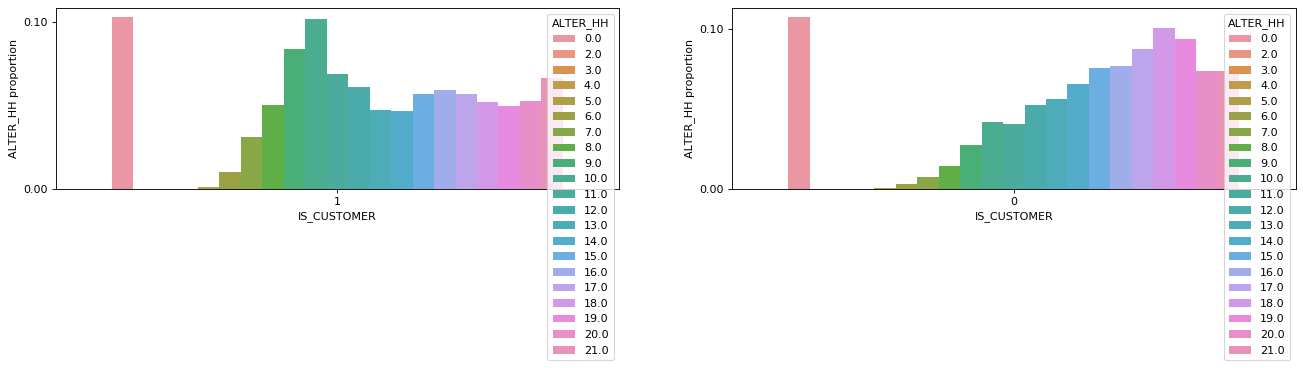

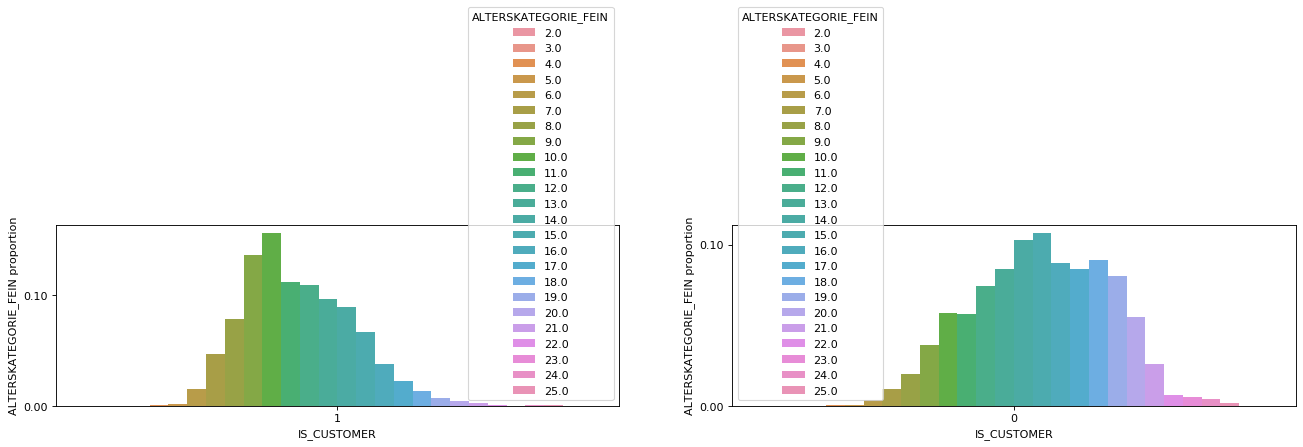

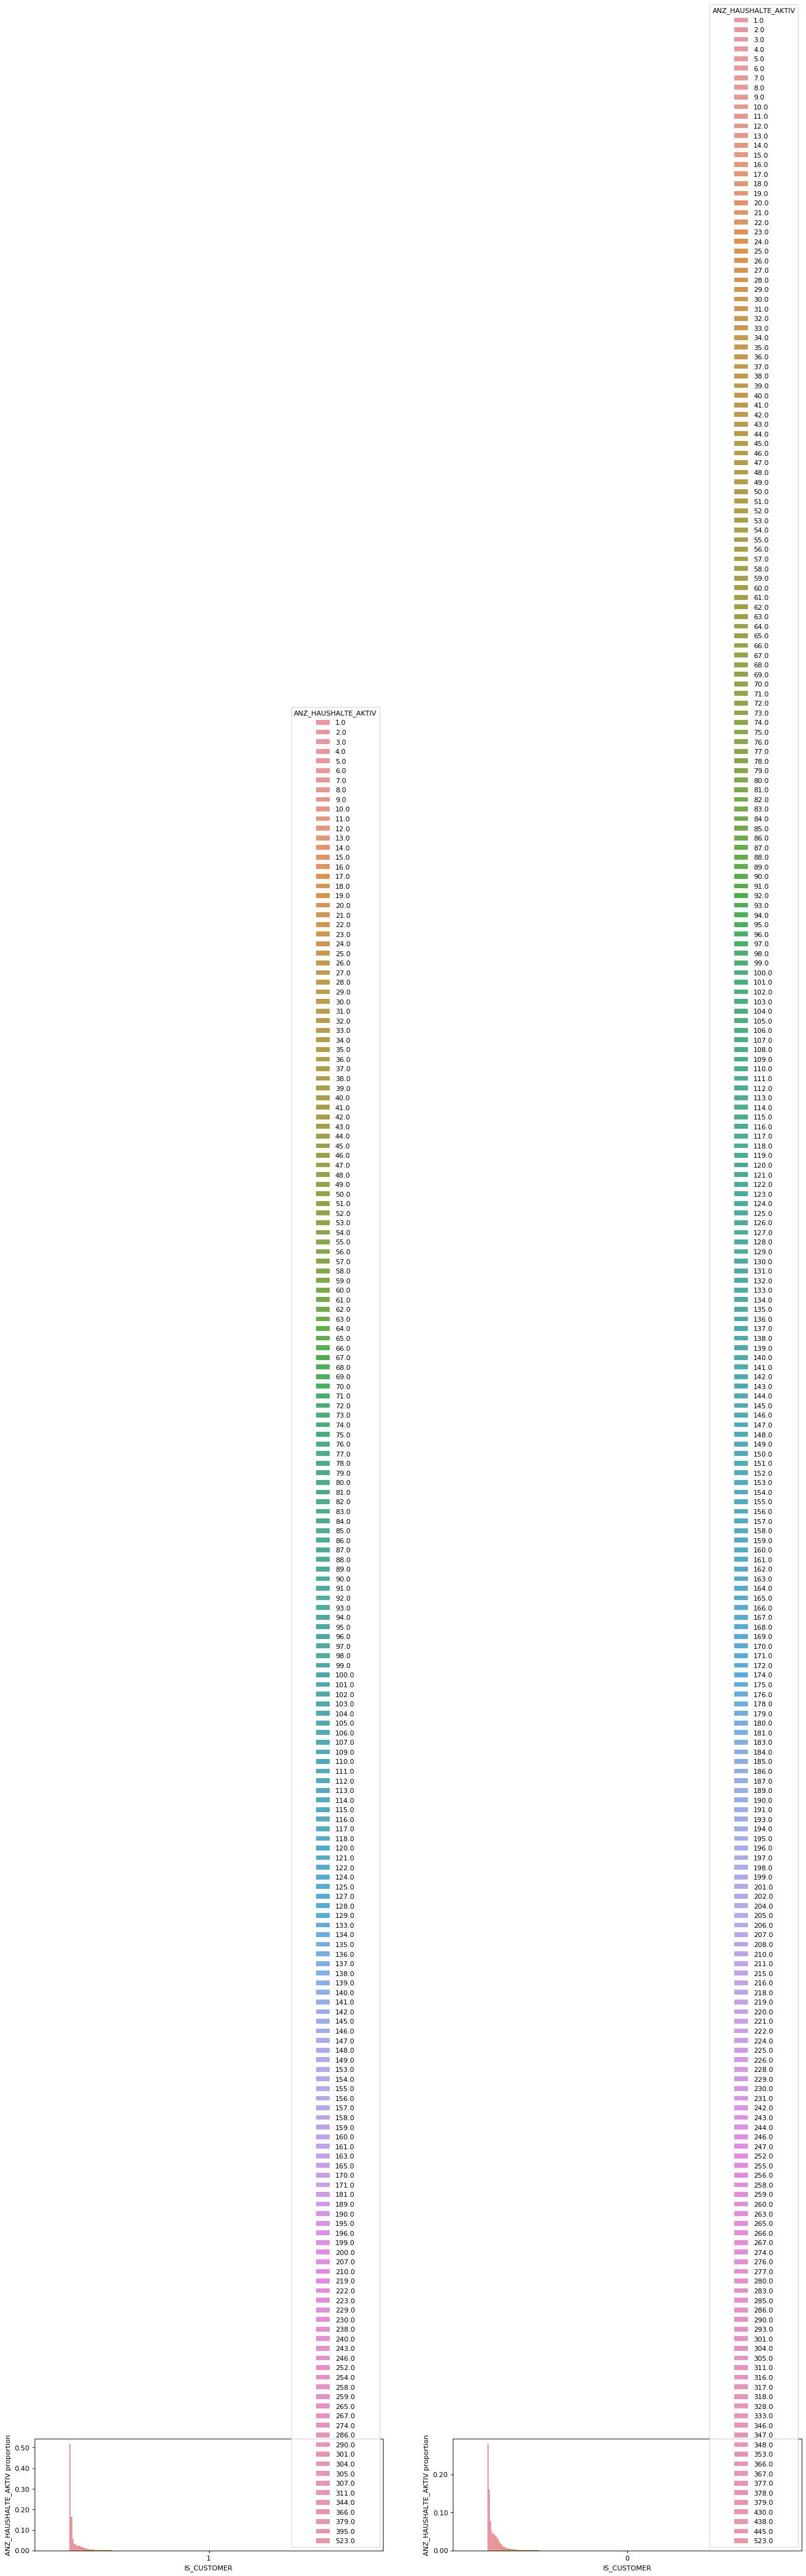

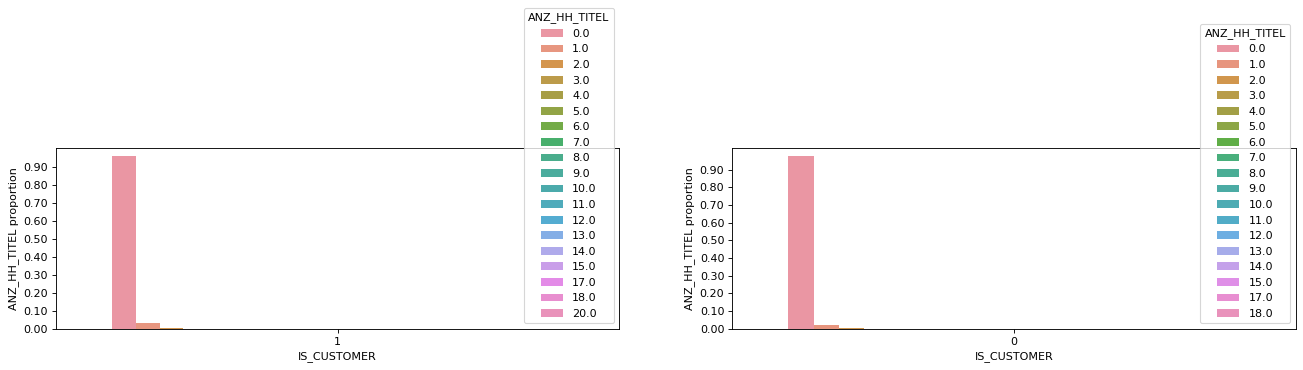

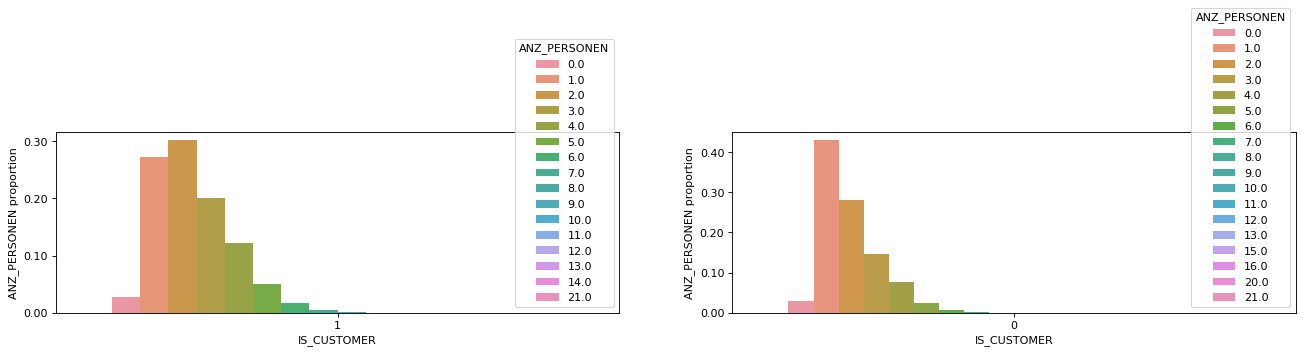

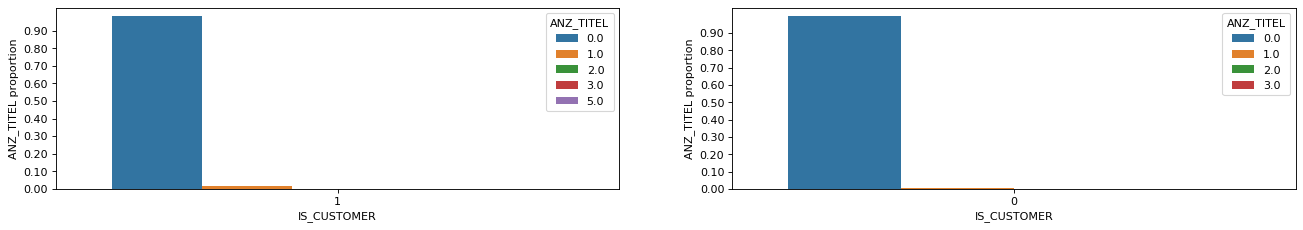

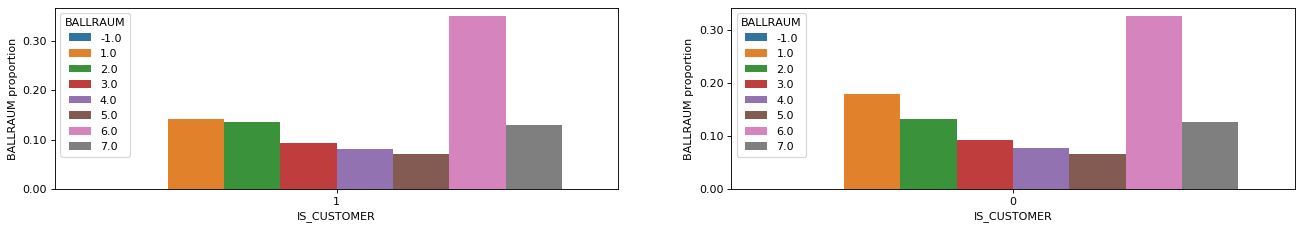

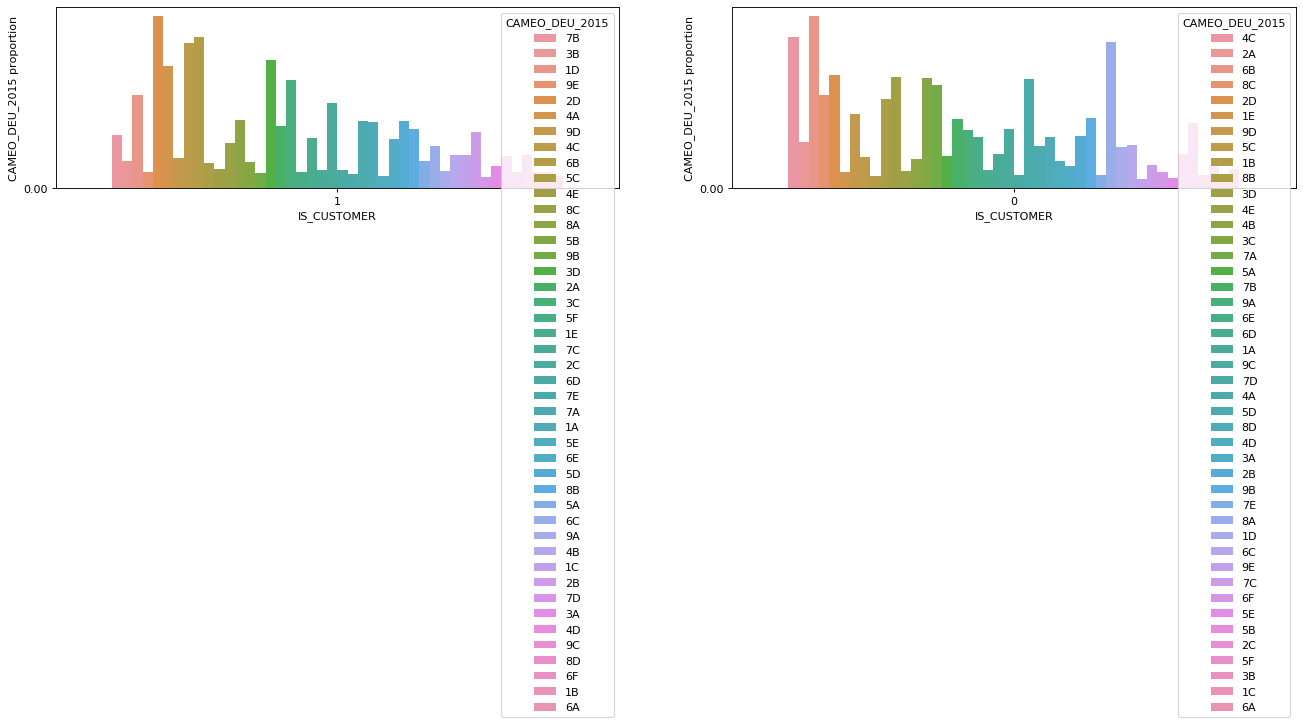

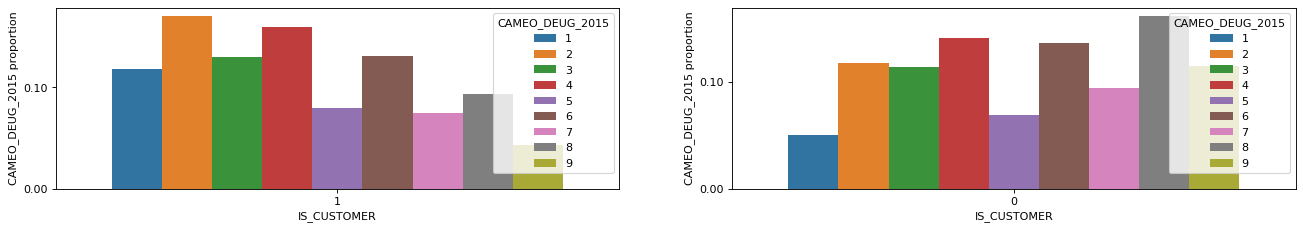

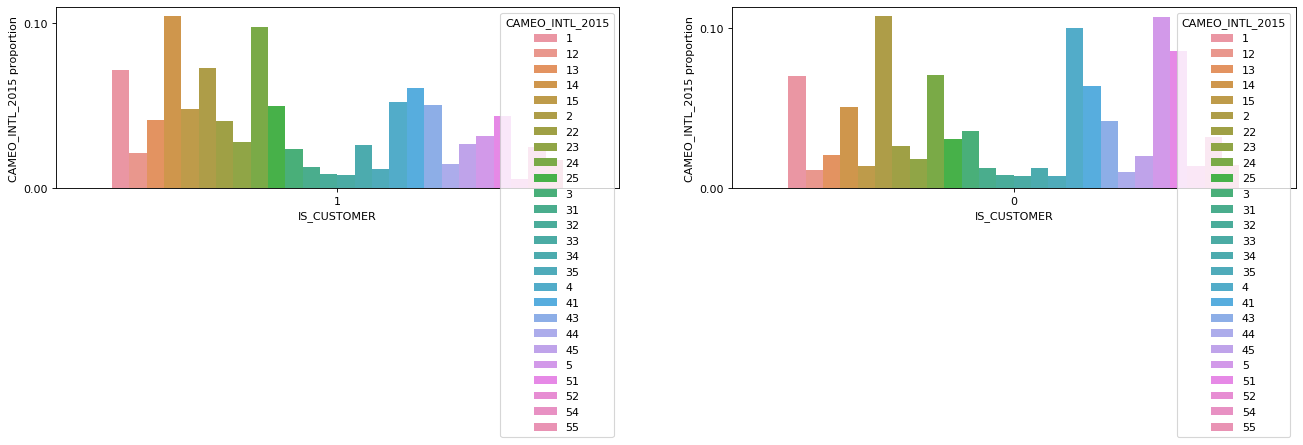

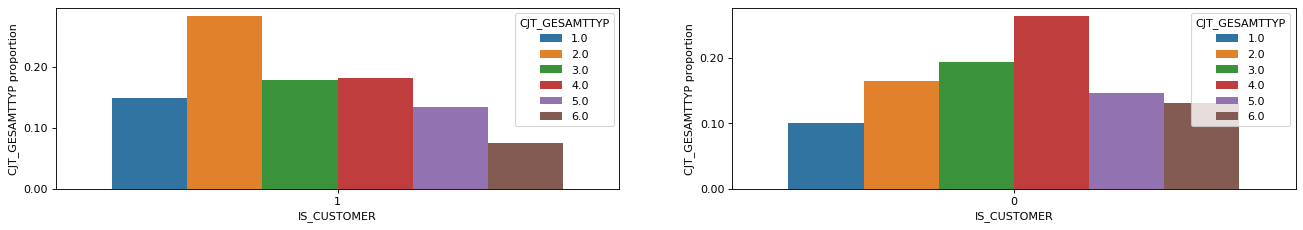

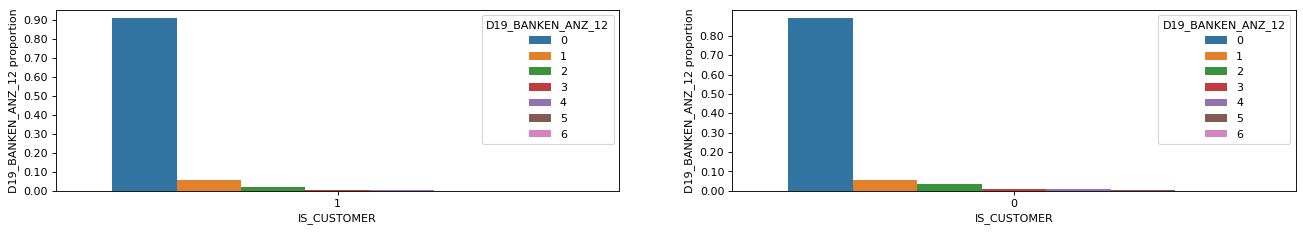

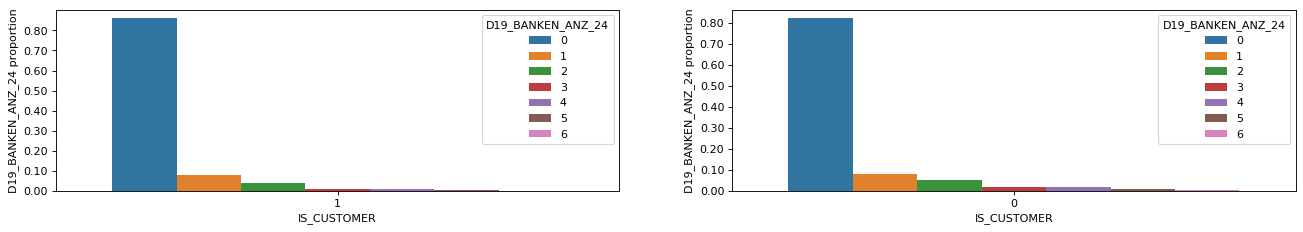

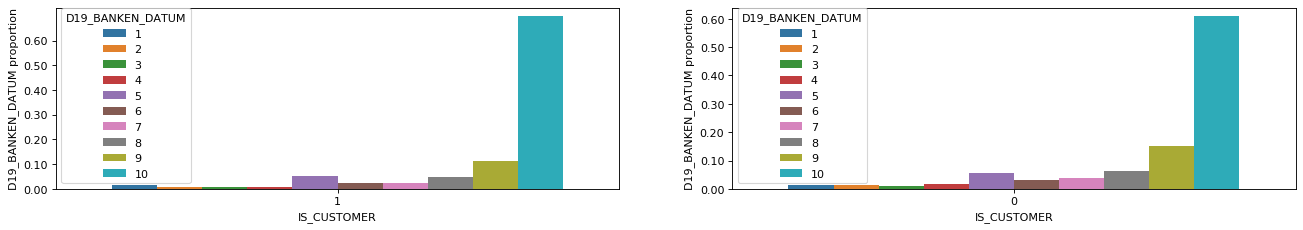

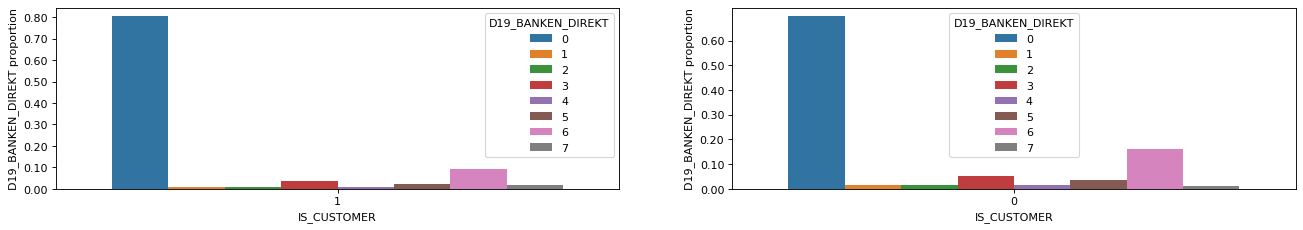

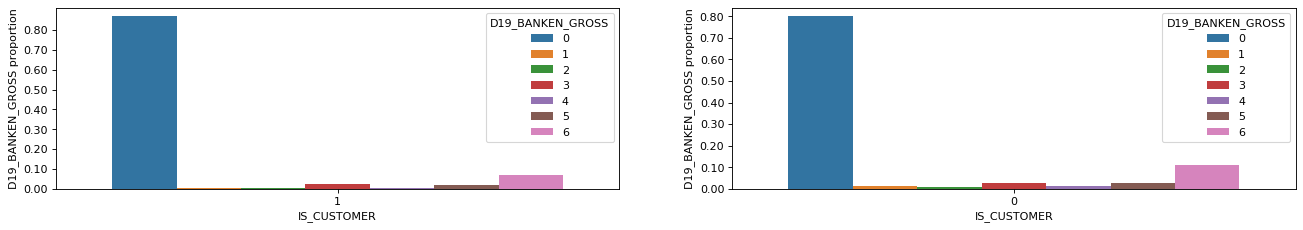

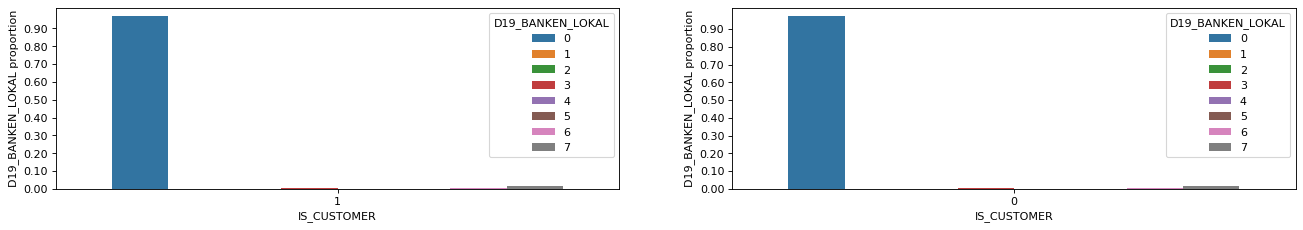

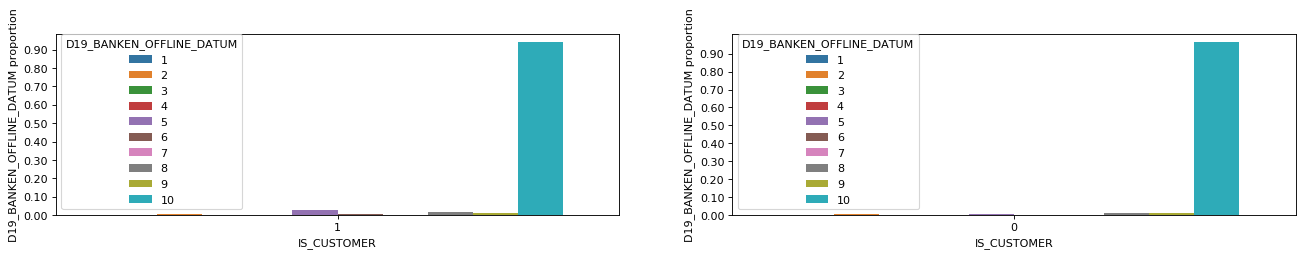

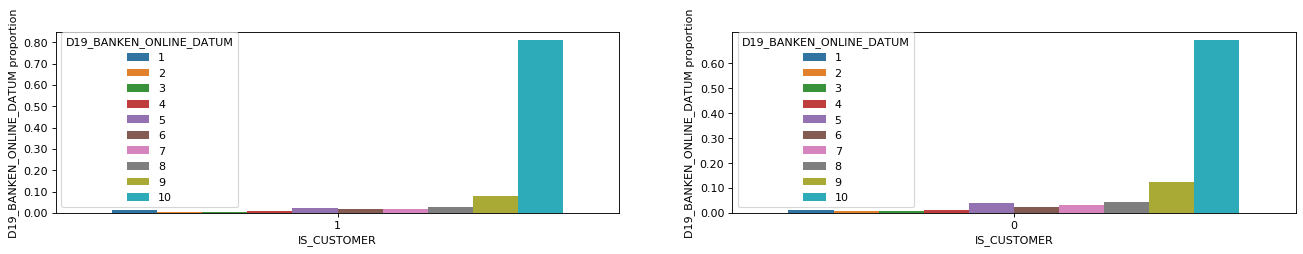

In [120]:
for col in customers.columns[1:20]:
    fig=plt.figure(figsize=(20, 3), dpi= 80, facecolor='w', edgecolor='k')
    plot_attribute_value_proprtion(customers, col, 1)
    plot_attribute_value_proprtion(azdias, col, 2)

In [ ]:
fig=plt.figure(figsize=(16, 5), dpi= 80, facecolor='w', edgecolor='k')
plot_attribute_value_proprtion(customers, 'SEMIO_KULT', 1)
plot_attribute_value_proprtion(azdias, 'SEMIO_KULT', 2)

因为我们看到azdias和customers具有相同的列，我们将这两个数据集整合在一起

In [ ]:
all_data = azdias.append(customers)
all_data.to_pickle('unified_all_data.pkl')

In [ ]:
all_data.shape

In [ ]:
plt.scatter(data=all_data.sample(100), x='IS_CUSTOMER', y='WOHNLAGE')
plt.xlabel('IS_CUSTOMER')
plt.ylabel('WOHNLAGE')

In [ ]:
import os
def convertToDummiesAndSave(dataframe, filename):
    data = dataframe.astype(str).replace('-1', np.nan)
    dummies = pd.get_dummies(data, prefix_sep='__', sparse=True)
    print(f'get_dummies result will be saved in {filename}.')

    if os.path.exists(filename):
        print(f'{filename} is already exist, will be deleted then save')
        os.remove(filename)
    
    dummies.to_pickle(filename)

    return dummies

In [ ]:
%%time
# this takes long
customers_df = convertToDummiesAndSave(customers, 'customers_dummies.pkl')

In [ ]:
%%time
# this takes long
azdias_df = convertToDummiesAndSave(azdias, 'azdias_dummies.pkl')

In [ ]:
%%time
# this takes long
all_data_df = convertToDummiesAndSave(all_data, 'all_data_dummies.pkl')
print(all_data_df.shape)
all_data.head()

## 第1部分：顾客分类报告

项目报告的主体部分应该就是这部分。在这个部分，你应该使用非监督学习技术来刻画公司已有顾客和德国一般人群的人口统计数据的关系。这部分做完后，你应该能够描述一般人群中的哪一类人更可能是邮购公司的主要核心顾客，哪些人则很可能不是。

In [ ]:
all_data_df = pd.read_pickle('all_data_dummies.pkl')
all_data_df.head()

In [ ]:
azdias_df = pd.read_pickle('azdias_dummies.pkl')
azdias_df.drop('IS_CUSTOMER__0', axis=1, inplace=True, errors='ignore')
azdias_df['IS_CUSTOMER'] = 0
azdias_df.head()

In [ ]:
customers_df = pd.read_pickle('customers_dummies.pkl')
customers_df.drop('IS_CUSTOMER__1',axis=1, inplace=True, errors='ignore')
customers_df['IS_CUSTOMER'] = 1
customers_df.head()

In [ ]:
special_columns = set(azdias_df.columns)-set(customers_df.columns)

In [ ]:
all_data_df.drop('IS_CUSTOMER__0', axis = 1, inplace = True, errors='ignore')
all_data_df = all_data_df.rename(columns={"IS_CUSTOMER__1": "IS_CUSTOMER"})

In [ ]:
'IS_CUSTOMER' in all_data_df

In [ ]:
all_data_df.head()

In [ ]:
azdias_df = pd.read_pickle('azdias_dummies.pkl')
azdias_df.head()

In [ ]:
customers_df = pd.read_pickle('customers_dummies.pkl')
customers_df.head()

In [ ]:
print( azdias_df.info(), customers_df.info(), all_data_df.info() )

In [ ]:
selected_features = set(azdias_df.columns).intersection(set(customers_df.columns))
print( f'there are {len(selected_features)} attributes_value intersection between azdias and customers' )

这里我们看到在azdias列的数量大于customers中，这里表示，在azdias中有多余的特征值在customers个完全没有的。我们来具体看看这是也那些特征。这些特征和值市可以刻画azdias与customers明显差异的，我们可以优先选择。

这里我们看到两个特征表中一共有2272不同的特征，这里我们使用这些特征开始做非监督学习。我们首先创建两个单独的DataFrame保留IS_CUSTOMER。

In [ ]:
customers_flag = pd.DataFrame(np.ones_like(customers.index), index=customers.index, columns=['IS_CUSTOMER'])
azdias_flag = pd.DataFrame(np.zeros_like(azdias.index), index=azdias.index, columns=['IS_CUSTOMER'])

all_customer_flag = pd.concat([customers_df, azdias_df])

我们先就单独选取上面的这些Attributes来作第一步实验。先将这些特征列从azdias中提取出来。

In [ ]:
all_selected_df = all_data_df[special_columns]
all_selected_df.shape

In [116]:
# Import sklearn's cluster module
from sklearn import cluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_score

In [ ]:
all_data_df.shape

In [ ]:
selected_features.add('IS_CUSTOMER')



In [118]:
X = dummies.sample(frac=0.5, random_state=1)
X

,KBA13_FAB_SONSTIGE__1,KBA13_FAB_SONSTIGE__2,KBA13_FAB_SONSTIGE__3,KBA13_FAB_SONSTIGE__4,KBA13_FAB_SONSTIGE__5,KBA13_TOYOTA__1,KBA13_TOYOTA__2,KBA13_TOYOTA__3,KBA13_TOYOTA__4,KBA13_TOYOTA__5,...,D19_BANKEN_ONLINE_DATUM__4,D19_BANKEN_ONLINE_DATUM__5,D19_BANKEN_ONLINE_DATUM__6,D19_BANKEN_ONLINE_DATUM__7,D19_BANKEN_ONLINE_DATUM__8,D19_BANKEN_ONLINE_DATUM__9,ANZ_HAUSHALTE_AKTIV,KBA13_ANZAHL_PKW,GEBURTSJAHR,IS_CUSTOMER
LNR,,,,,,,,,,,,,,,,,,,,,
1015852,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,14.0,395.0,1958.0,0
984309,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1.0,934.0,1939.0,0
361609,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,12.0,701.0,1971.0,0
197199,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,1,0,1.0,736.0,1976.0,0
575359,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1.0,573.0,1968.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117651,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1.0,552.0,1943.0,1
372109,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,4.0,583.0,1953.0,0
893956,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,2.0,518.0,1956.0,0


In [ ]:
%%time
for i in range(2, 10):
    # Try instantiating a model with 2 centers
    kmeans = KMeans(n_clusters=i)  # Then fit the model to your data using the fit mdel_2 = kmeans_2.fit(subset_data)
    cluster = kmeans.fit(X)
    
    print('clusters=', i, 'silhouette_score=', silhouette_score(X, cluster.labels_), 'inertia_=', cluster.inertia_)

clusters= 2 silhouette_score= 0.6084140817246088 inertia_= 10344449763.926928
clusters= 3 silhouette_score= 0.5339546978549395 inertia_= 5403422095.735538
clusters= 4 silhouette_score= 0.5144296859561636 inertia_= 3210961840.283775
clusters= 5 silhouette_score= 0.4949307644927472 inertia_= 2199828824.6216607
clusters= 6 silhouette_score= 0.4745153065676067 inertia_= 1684572284.0424933
clusters= 7 silhouette_score= 0.47323088490314363 inertia_= 1291796688.062993
clusters= 8 silhouette_score= 0.4572636846361981 inertia_= 1038233809.9214194


In [ ]:
# Finally predict the labels on the same data to show the category that point belongs to
predict_labels = module.predict(X)

In [ ]:
all_data_df.reset_index()

In [ ]:
all_data_df.plot.scatter(x='AGER_TYP__1',y='AGER_TYP__0', c='DarkBlue')

In [ ]:
%%time
#create an instance of DBSCAN
dbscan = DBSCAN(eps=3, min_samples=2)
#use DBSCAN's fit_predict to return clustering labels for dataset_1
dbscan_labelsel = dbscan.fit(subset_data)      
pringt(dbscan_labels)

In [ ]:
len(clustering)

## 第2部分：监督学习模型

你现在应该已经发现哪部分人更可能成为邮购公司的顾客了，是时候搭建一个预测模型了。"MAILOUT"数据文件的的每一行表示一个邮购活动的潜在顾客。理想情况下我们应该能够使用每个人的人口统计数据来决定是否该把他作为该活动的营销对象。

"MAILOUT" 数据被分成了两个大致相等的部分，每部分大概有 43 000 行数据。在这部分，你可以用"TRAIN"部分来检验你的模型，该数据集包括一列"RESPONSE"，该列表示该对象是否参加了该公司的邮购活动。在下一部分，你需要在"TEST"数据集上做出预测，该数据集中"RESPONSE" 列也被保留了。

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [ ]:
mailout_train = pd.read_csv(drive_path+'Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [ ]:
mailout_train.head

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')